<a href="https://colab.research.google.com/github/vedantdave77/project.Orca/blob/master/Generative%20Adversarial%20Networks/Cycle_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cycle GAN - Image to Image translation

AIM: Here, I will generate new natural image with Cycle GAN. The data is taken from Yosemite National Park in different seasons. 

The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa).



## Concept: Unpaired Data

The dataset images have no labels so it will be unsupervised machine learning problem. A cycle GAN is specially designed to image to image translation and it learn from **unpaired data**, that means we do not need any direct relationship between individual image to specific domain. (desired output domain)

For example, inthe papaer **"Unpaired Image-to-Image Translation
using Cycle-Consistent Adversarial Networks"**, researcher can convert horse to zebra with background change.

## Import Libraries

In [1]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
% matplotlib inline 

import numpy as np
import warnings


## DataLoaders

Generate dataloader for train and test dataset. Prepare datasets.

In [2]:
def get_data_loader(image_type, image_dir = '/content/drive/My Drive/summer2winter_yosemite', image_size = 128, batch_size = 16, num_workers = 0):
  transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])
  image_path = image_dir
  train_path = os.path.join(image_path, image_type)
  test_path = os.path.join(image_path, 'test_{}'.format(image_type))

  # generate datasets
  train_dataset = datasets.ImageFolder(train_path, transform)
  test_dataset = datasets.ImageFolder(test_path, transform)
   
  # generate loaders 
  train_loader = DataLoader(dataset= train_dataset, batch_size = batch_size, shuffle=True, num_workers = num_workers)
  test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers)

  return train_loader, test_loader

In [3]:
# create datasets for two domains
dataloader_X, test_dataloader_X = get_data_loader(image_type = 'summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type = 'winter')

## Display images for reference 

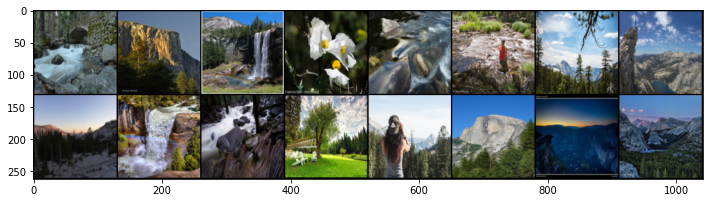

In [4]:
def imshow(img):
  img = img.numpy()
  plt.imshow(np.transpose(img,(1,2,0)))

dataiter = iter(dataloader_X)
images,_ = dataiter.next()

fig = plt.figure(figsize= (12,8))
imshow(torchvision.utils.make_grid(images))

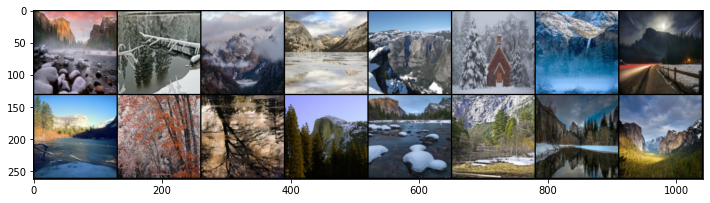

In [5]:
# now, get images from y domain
dataiter =iter(dataloader_Y)
images,_ = dataiter.next()

# show images
fig = plt.figure(figsize = (12,8))
imshow(torchvision.utils.make_grid(images))

## Preprocessing

Scaling form (-1,1). 

In [6]:
image = images[0]
print(image.size())

print("Min: ", image.min())
print("Max: ",image.max())

torch.Size([3, 128, 128])
Min:  tensor(0.)
Max:  tensor(0.9882)


In [7]:
# convert image scale
def scale(x,feature_range = (-1,1)):
  min, max = feature_range
  x = x* (max-min) + min
  return x

In [8]:
# image conversion
scaled_image = scale(image)

print("Scaled Image Min: ", scaled_image.min())
print("Scaled Image Max: ", scaled_image.max())


Scaled Image Min:  tensor(-1.)
Scaled Image Max:  tensor(0.9765)


## Define Model

Cycle GAN is different than normal GAN, which has two discriminators and two generators seperated in each cycle. Here, I will define the discriminator and generator first using **init** method. Then I will define the real network architecture flow.

I will refer the Research paper for that, due to limited computation power, I will use higher convolution transformation ratio (layer-to-layer Incrementation).



### Discriminator
Discriminator is simple powerful classification Neural Network.

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. 

Refering the paper, This network sees a 128x128x3 image, and passes it through 6 convolutional layers that downsample the image by a factor of 2. And, for 256x256x3 they use 9 Bloacks. The first five convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

In [9]:
# Define Convolution layer [Reason: Due to batch normalization after specific layers]
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm = True):
  layers = []
  conv_layer = nn.Conv2d(in_channels = in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)           # due to batch normalization we can not consider bias
  layers.append(conv_layer)

  if batch_norm==True:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

I will construct 5 block discriminator for 128x128x3 images. According to paper, I will use kernel size = 4x4 and stride and padding size are same as predefined conv layers.

In [10]:
# construct Discriminator

class Discriminator(nn.Module):
  def __init__(self,conv_dim = 64):
    super(Discriminator, self).__init__()

    self.conv1 = conv(3, conv_dim, 4, batch_norm = False)               # 64,64,64
    self.conv2 = conv(conv_dim, conv_dim*2, 4)                          # 32,32,128
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4)                        # 16,16,256
    self.conv4 = conv(conv_dim*4, conv_dim*8, 4)                        # 8,8,512

    self.conv5 = conv(conv_dim*8,1,4,stride = 1, batch_norm = False)                # flatten the output

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    out = self.conv5(x)
    return out

### Generator

The generators, G_XtoY and G_YtoX (sometimes called F), are made of **an encoder, a conv net** that is responsible for turning an image into a smaller feature representation, and a **decoder, a transpose_conv net** that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX. 

My network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of **residual blocks.** 

> *It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called de-conv layers) which upsample the output of the resnet blocks and create a new image!*

I will replicate my generator architecture with the paper, in which I will use Batch_Norm and relu function to all the network layers and apply tanh function to last layer. output(-1 to 1)

## Residual Block

Residual Block is used in the Neural Network, when we have deep netwok. The main problem with deep network is vanishing or exploding gradient. So, due to such problem skip type network is used to maintain depth without parametric level loss. Here, in generator, I will use 2 residual block between encoder and decoder type of network. 



In [11]:
# construct residual block.
class Residual_block(nn.Module):
  def __init__(self,conv_dim):
    super(Residual_block,self).__init__()

    self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1,batch_norm =True)
    self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1,batch_norm =True)

  def forward(self,x):
    op1 = F.relu(self.conv_layer1(x))
    op2 = x + self.conv_layer2(op1)
    return op2

In [43]:
# define deconv function (due to batch normalization)
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm = True):
  layers = []
  conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)           # due to batch normalization we can not consider bias
  layers.append(conv_layer)

  if batch_norm==True:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

In [44]:
# construct Generator Architecture
class Cycle_Generator(nn.Module):
  def __init__(self,conv_dim = 64,n_residual_blocks =6):
    super(Cycle_Generator,self).__init__()

    self.conv1 = conv(3,conv_dim,4)
    self.conv2 = conv(conv_dim,conv_dim*2,4)
    self.conv3 = conv(conv_dim*2,conv_dim*4,4)
    
    residual_layers = []
    for layer in range(n_residual_blocks):
      residual_layers.append(Residual_block(conv_dim*4))
    self.residual_blocks = nn.Sequential(*residual_layers)
    
    self.deconv1 = deconv(conv_dim*4,conv_dim*2,4)
    self.deconv2 = deconv(conv_dim*2,conv_dim,4)
    self.deconv3 = deconv(conv_dim,3, 4, batch_norm = False)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    Eop = F.relu(self.conv3(x))

    Rop = self.residual_blocks(Eop)

    y = F.relu(self.deconv1(Rop))
    y = F.relu(self.deconv2(y))
    Dop = F.tanh(self.deconv3(y))                                # tanh 

    return Dop

In [45]:
# Finalize Model
def cycle_model(g_conv_dim= 64, d_conv_dim = 64, n_res_block = 6):
  gen_xtoy = Cycle_Generator(conv_dim = g_conv_dim, n_residual_blocks = n_res_block)
  gen_ytox = Cycle_Generator(conv_dim = g_conv_dim, n_residual_blocks = n_res_block)

  dis_x = Discriminator(conv_dim = d_conv_dim)
  dis_y = Discriminator(conv_dim = d_conv_dim)

  if torch.cuda.is_available():
    device = torch.device("cuda:0")
    gen_xtoy.to(device)
    gen_ytox.to(device)
    dis_x.to(device)
    dis_y.to(device)
    print('Model is on the GPU, life is easy!')
  else:
    print('Model will run on CPU, close other programs and browsers for RAM optimization, do not forget to charge!, meet you tomorrow.')
  
  return gen_xtoy, gen_ytox, dis_x, dis_y

In [46]:
# call the above function
gen_xtoy, gen_ytox, dis_x, dis_y = cycle_model()

Model is on the GPU, life is easy!


### Print Model


In [47]:
def print_models(gen_xtoy, gen_ytox, dis_x, dis_y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(gen_xtoy)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(gen_ytox)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(dis_x)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(dis_y)
    print()

In [48]:
# print all of the models
print_models(gen_xtoy, gen_ytox, dis_x, dis_y)

                     G_XtoY                    
-----------------------------------------------
Cycle_Generator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (residual_blocks): Sequential(
    (0): Residual_block(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

## Losses [Generator / Discriminator]

Mostly we use cross entropy loss, but in GAN networks such loss lead to gradint vanishing problem. LSGAN was the first paper in which the Least Square Loss function was used and successfully solved this problem. Here, I will implement MSE loss method. 

* **real_mse_loss** that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
* **fake_mse_loss** that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
* **cycle_consistency_loss** that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a lambda_weight parameter that will weight the mean absolute error in a batch



In [49]:
def real_mse_loss(D_out):
  return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
  return torch.mean((D_out)**2)

def cycle_consistency_loss(real_image, reconstructed_image, lambda_weight):
  reconstruct_loss = torch.mean(torch.abs(real_image-reconstructed_image))
  return lambda_weight * reconstruct_loss

Define Optimizer 

In [55]:
import torch.optim as optim

# hyper parameters
lr = 0.0003                           # previous => 0.01, 0.001,0.0001, 0.002
beta1 = 0.5
beta2 = 0.999

g_params = list(gen_xtoy.parameters()) + list(gen_ytox.parameters())

# create optimizer for generation and discriminators
gen_optimizer = optim.Adam(g_params, lr, [beta1,beta2])
d_x_optimizer = optim.Adam(dis_x.parameters(), lr, [beta1,beta2])
d_y_optimizer = optim.Adam(dis_y.parameters(), lr, [beta1,beta2])

## Training CycleGAN 

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**

1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images indomain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!

**Training the Generators**

1. Generate fake images that look like domain $X$ based on real images in 2. domain $Y$
3. Compute the generator loss based on how $D_X$ responds to fake $X$
4. Generate reconstructed $\hat{Y}$ images based on the fake $X$ images generated in step 1
5. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
6. Repeat steps 1-4 only swapping domains
7. Add up all the generator and reconstruction losses and perform backpropagation + optimization

In [56]:
# import data loading libraries
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

# import torch
import torch


# numpy & scipy imports
import numpy as np
import scipy
import scipy.misc


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    

def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    scipy.misc.imsave(path, merged)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    scipy.misc.imsave(path, merged)
    print('Saved {}'.format(path))

In [57]:
test_y_temp = iter(test_dataloader_Y)
image_y,_ = test_y_temp.next()
print(image_y.size())
image_y = scale(image_y)
print(image_y.size())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_y = image_y.to(device)
fake_x = gen_ytox(image_y)
print(fake_x.size())
output_x = dis_x(fake_x)


torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


In [60]:
# ==================
# | Train a Netwok |
# ==================

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y,n_epochs = 1000):
  # define local variable and set
  print_every = 50
  losses = []

  test_iter_x = iter(test_dataloader_X)
  test_iter_y = iter(test_dataloader_Y)

  # take fixed sampling. 
  fixed_x = test_iter_x.next()[0]
  fixed_x = scale(fixed_x)
  fixed_y = test_iter_y.next()[0]
  fixed_y = scale(fixed_y)

  # no. of batches per epoch 
  iter_x = iter(dataloader_X)
  iter_y = iter(dataloader_Y)
  batches_per_epoch = min(len(iter_x),len(iter_y))

  for epoch in range(1,n_epochs+1):
    if epoch % batches_per_epoch==0:
      iter_x = iter(dataloader_X)
      iter_y = iter(dataloader_Y)

    images_x,_ = iter_x.next()
    images_x = scale(images_x)
    images_y,_ = iter_y.next()
    images_y = scale(images_y)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    images_x = images_x.to(device)
    images_y = images_y.to(device)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #        |   DISCRIMINATOR TRAINING PHASE   |
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # FIRST: dis_x components 
    ## real images
    d_x_optimizer.zero_grad()
    output_x = dis_x(images_x)
    dis_x_real_loss = real_mse_loss(output_x)

    ## fake images
    fake_x = gen_ytox(images_y)
    output_x = dis_x(fake_x)
    dis_x_fake_loss = fake_mse_loss(output_x)

    ### total loss and backpropagation 
    dis_x_total = dis_x_real_loss + dis_x_fake_loss
    dis_x_total.backward()
    d_x_optimizer.step()

    # SECOND: dis_y components
    ## real images
    d_y_optimizer.zero_grad()
    output_y = dis_y(images_y)
    dis_y_real_loss = real_mse_loss(output_y)

    ## fake images
    fake_y = gen_xtoy(images_x)
    output_y = dis_y(fake_y)
    dis_y_fake_loss = fake_mse_loss(output_y)

    ### total loss and backpropagation 
    dis_y_total = dis_y_real_loss + dis_y_fake_loss
    dis_y_total.backward()
    d_y_optimizer.step()       

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #         |     GENERATOR TRAINING PHASE    |
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    gen_optimizer.zero_grad()

    ## fake_x image generation and reconstruct y images
    fake_x = gen_ytox(images_y)
    output_x = dis_x(fake_x)
    gen_ytox_loss = real_mse_loss(output_x)
    reconstructed_y = gen_xtoy(fake_x)
    reconstructed_y_loss = cycle_consistency_loss(image_y,reconstructed_y,lambda_weight=10)

    ## fake_y image generation and then reconstruct x images
    fake_y = gen_xtoy(images_x)
    output_y = dis_y(fake_y)
    gen_xtoy_loss = real_mse_loss(output_y)
    reconstructed_x = gen_ytox(fake_y)
    reconstructed_x_loss = cycle_consistency_loss(images_x, reconstructed_x, lambda_weight=10)

    # add losses and back propagation
    gen_total_loss = gen_xtoy_loss + gen_ytox_loss + reconstructed_x_loss + reconstructed_y_loss
    gen_total_loss.backward()
    gen_optimizer.step()

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # prining information by batch and epoch
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if epoch % print_every == 0:
      losses.append(dis_x_loss.item(), dis_y_loss.item(), g_total_loss.item())
      print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, dis_x_loss.item(), dis_y_loss.item(), gen_total_loss.item()))
      
    

    # saving samples 
    sample_every = 100 
    if epoch % sample_every == 0:
      gen_ytox.eval()
      gen_xtoy.eval()
      save_samples(epoch, fixed_y, fixed_x, gen_xtoy, gen_ytox, batch_size = 16)
      gen_ytox.train()
      gen_xtoy.train()

    checkpoint_every = 1000
    if epoch % checkpoint_every ==0:
      checkpoint(epoch, gen_xtoy, gen_ytox, dis_x, dis_y)
  
  return losses

In [61]:
n_epochs = 4000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs = n_epochs)

# IT MUST TAKE SOMETIME [depend on you GPU] 

NameError: ignored

# Training and Loss Pattern



In [ ]:
fig, ax = plt.subplot(figsize = (12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label= 'Discriminator X', alpha=0.6)
plt.plot(losses.T[1], label= 'Discriminator Y', alpha=0.6)
plt.plot(losses.T[2], label= 'Generator', alpha=0.6)
plt.title('Training Losses Comparison')
plt.legend()

## Visualize Samples

In [ ]:
import matplotlib.image as image

def view_samples(iteration, sample_dir= 'samples_cyclegen'):
  path_xtoy = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png', format(iteration))
  path_ytox = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png', format(iteration))

  try:
    xtoy = image.imread(path_xtoy)
    ytox = image.imread(path_ytox)
  except:
    print('Invalid number of iterations')

    fig, (ax1,ax2) = pltsubplots(figsize=(18,20),nrows=2, ncols=1, sharey = True, sharex=True)
    ax1.imshow(xtoy)
    ax1.set_title('X to Y')
    ax2.imshow(ytox)
    ax2.set_title('Y to X')

In [ ]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

In [ ]:
# view samples at iteration 100
view_samples(4000, 'samples_cyclegan')

In [ ]:
# keep learning, enjoy empowering 